GAN Mini-Project: Monet-Style Image Generation


## Introduction

I decided to work on the Kaggle 'I’m Something of a Painter Myself" competition this week. The main goal is to build a simple GAN that can take a photo and output a Monet-style painting.  

**Problem:**  
* Build a generative model GAN to translate between “photo” and “Monet painting” domains.

####  Dataset Description
* The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

### Files
- monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
- monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
- photo_jpg - 7028 photos sized 256x256 in JPEG format
- photo_tfrec - 7028 photos sized 256x256 in TFRecord format


* I analyzed these notebooks: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial --- https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings

In [24]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kaggle_datasets import KaggleDatasets
import glob

In [25]:
GCS_PATH = KaggleDatasets().get_gcs_path()
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

In [26]:
print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')

Monet TFRecord files: 5
Photo TFRecord files: 20


### How many image we have

In [27]:
monet_folder = '/kaggle/input/gan-getting-started/monet_jpg'
photo_folder = '/kaggle/input/gan-getting-started/photo_jpg/'

monet_files = glob.glob(os.path.join(monet_folder, '*.jpg'))
photo_files = glob.glob(os.path.join(photo_folder, '*.jpg'))

print(f"Number of Monet images: {len(monet_files)}")
print(f"Number of Photo images: {len(photo_files)}")  



Number of Monet images: 300
Number of Photo images: 7038


### Exploratory Data Analysis (EDA)

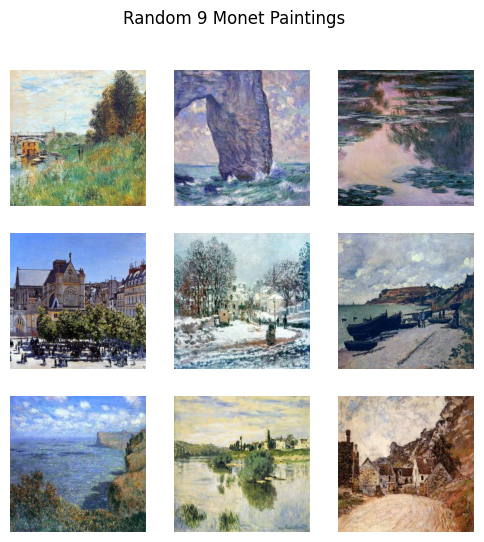

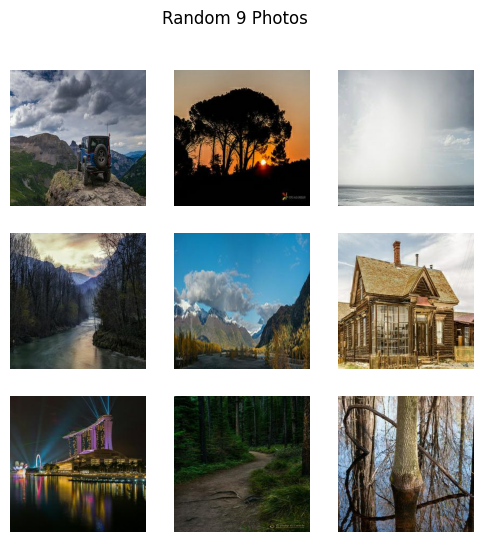

In [28]:


#this function loads random images
def load_random_image(folder, size=(256, 256)):
    fname = random.choice(os.listdir(folder))
    img = Image.open(os.path.join(folder, fname)).resize(size)
    return np.array(img)

plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = load_random_image(monet_folder)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Random 9 Monet Paintings")
plt.show()

plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = load_random_image(photo_folder)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Random 9 Photos")
plt.show()


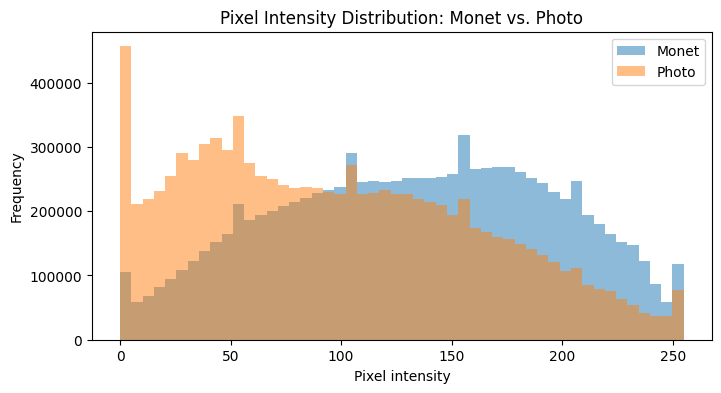

In [29]:

def pixel_histogram(folder, num_samples=50):
    all_pixels = []
    samples = random.sample(os.listdir(folder), num_samples)
    for fname in samples:
        img = np.array(Image.open(os.path.join(folder, fname)).resize((256, 256)))
       
        all_pixels.extend(img.flatten())
    return np.array(all_pixels)

monet_pixels = pixel_histogram(monet_folder, num_samples=50)
photo_pixels = pixel_histogram(photo_folder, num_samples=50)

plt.figure(figsize=(8, 4))
plt.hist(monet_pixels, bins=50, alpha=0.5, label='Monet')
plt.hist(photo_pixels, bins=50, alpha=0.5, label='Photo')
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")
plt.legend()
plt.title("Pixel Intensity Distribution: Monet vs. Photo")
plt.show()


**EDA Comments:**  
- All images are 256×256×3.  
- The Monet pixel histogram is slightly narrower compared to photos.  
- No obvious corrupted files.  
- Colors are very diverse in these examples

## Model Architecture

- I’m not trying to beat state-of-the-art; I just want to show a working GAN.
- encoder-decoder style with same spatial dimensions, the reason is we want to preserve photo structure while changing style.


#### Why I chose this architecture:
I went with an encoder-decoder setup because it keeps the spatial structure intact while still allowing for the kind of style transformation we need.

The input and output images have the same dimensions since we're doing a direct photo-to-painting conversion.

I used a progressive increase in the number of channels (and then a decrease) to help the model capture features at multiple levels of detail.

Batch normalization is included to stabilize training.

For the output layer, I used a tanh activation so that the values fall in the (-1,1) range, which aligns with how the input images were normalized.

* **Generator**:
     - Uses encoder-decoder style
     - 6 Conv2D layers gradually learn style transformation"
- **Discriminator**:
    - Progressive downsampling: 256,12,864,32,16 output a single probability (real/fake).
    - LeakyReLU to avoid dead neurons


In [30]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 1
EPOCHS = 50

#### Code for Generator

In [31]:
def build_photo_to_monet_generator():
   
    model = tf.keras.Sequential(name="Photo_to_Monet_Generator")
    
    
    model.add(tf.keras.layers.Conv2D(64, (7,7), strides=(1,1), padding='same', 
                                     input_shape=[256, 256, 3]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    
    model.add(tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    model.add(tf.keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    
    for _ in range(6):  # ResNet-style blocks
        x = model.output if hasattr(model, 'output') else None
        model.add(tf.keras.layers.Conv2D(256, (3,3), strides=(1,1), padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.Conv2D(256, (3,3), strides=(1,1), padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
    
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    
    model.add(tf.keras.layers.Conv2D(3, (7,7), strides=(1,1), padding='same', activation='tanh'))
    
    return model

In [32]:
def build_simple_photo_to_monet_generator():
    
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    # Apply artistic transformations
    x = tf.keras.layers.Conv2D(32, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # Style transformation layers
    x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(32, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # Output (Monet-style image)
    outputs = tf.keras.layers.Conv2D(3, 3, padding='same', activation='tanh')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="Simple_Photo_to_Monet")


#### Code for Discriminator

In [33]:
def build_discriminator():
    
    model = tf.keras.Sequential(name="Monet_Discriminator")
    
    model.add(tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', 
                                     input_shape=[256, 256, 3]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model


### Comments
* Input: 256×256×3

*  Flatten & Dense to single output

* Used sigmoid to output probability real/fake.

In [34]:
@tf.function
def train_step_photo_to_monet(real_photos, real_monet):
    
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generate fake Monet from real photos
        fake_monet = generator(real_photos, training=True)
        
        #discriminator outputs
        real_monet_output = discriminator(real_monet, training=True)
        fake_monet_output = discriminator(fake_monet, training=True)
        
       
        gen_loss = cross_entropy(tf.ones_like(fake_monet_output), fake_monet_output)
        
       
        disc_real_loss = cross_entropy(tf.ones_like(real_monet_output), real_monet_output)
        disc_fake_loss = cross_entropy(tf.zeros_like(fake_monet_output), fake_monet_output)
        disc_loss = (disc_real_loss + disc_fake_loss) * 0.5
        
    # gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [35]:
def train_photo_to_monet(photo_dataset, monet_dataset, epochs):
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_gen_loss = []
        epoch_disc_loss = []
        
        
        combined_ds = tf.data.Dataset.zip((photo_dataset, monet_dataset))
        
        for batch_num, (photo_batch, monet_batch) in enumerate(combined_ds):
            gen_loss, disc_loss = train_step_photo_to_monet(photo_batch, monet_batch)
            epoch_gen_loss.append(gen_loss)
            epoch_disc_loss.append(disc_loss)
            
            if batch_num % 20 == 0:
                print(f"  Batch {batch_num}: gen_loss={gen_loss:.3f}, disc_loss={disc_loss:.3f}")
        
       
        avg_gen_loss = tf.reduce_mean(epoch_gen_loss)
        avg_disc_loss = tf.reduce_mean(epoch_disc_loss)
        print(f"  → Epoch avg: gen_loss={avg_gen_loss:.3f}, disc_loss={avg_disc_loss:.3f}")
        
        
        if (epoch + 1) % 2 == 0:
            show_transformations(epoch + 1)

In [36]:
def show_transformations(epoch):
    
    fig, axes = plt.subplots(3, 2, figsize=(10, 12))
    
    for i, photo_batch in enumerate(photo_ds.take(3)):
        photo = photo_batch[0]
        transformed = generator(photo_batch, training=False)[0]
        
        # for display
        photo_display = (photo * 0.5 + 0.5).numpy()
        transformed_display = (transformed * 0.5 + 0.5).numpy()
        
        axes[i, 0].imshow(photo_display)
        axes[i, 0].set_title("Original Photo")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(transformed_display)
        axes[i, 1].set_title("Generated Monet ")
        axes[i, 1].axis('off')
    
    plt.suptitle(f"Photo-to-Monet Transformations - Epoch {epoch}")
    plt.tight_layout()
    plt.show()

## Data Preprocessing
* I didn’t use any data augmentation in this version because the training already takes a while and I wanted to keep it simple for now.
* Normalization: Converting pixel values from [0,255] to [-1,1] reason: Tanh activation in generator outputs [-1,1].
* No data cleaning needed.

In [37]:
def load_and_preprocess(path):
    
    img = Image.open(path).convert('RGB').resize((256, 256))
    arr = np.asarray(img).astype(np.float32)
    arr = (arr / 127.5) - 1.0  
    return arr

In [38]:
monet_images = []
for i, path in enumerate(monet_files):
    if i % 50 == 0:
        print(f"Loading Monet image {i+1}/{len(monet_files)}")
    monet_images.append(load_and_preprocess(path))
photo_images = []

for i, path in enumerate(photo_files):  
    if i % 100 == 0:
        print(f"Loading photo {i+1}/1000")
    photo_images.append(load_and_preprocess(path))


Loading Monet image 1/300
Loading Monet image 51/300
Loading Monet image 101/300
Loading Monet image 151/300
Loading Monet image 201/300
Loading Monet image 251/300
Loading photo 1/1000
Loading photo 101/1000
Loading photo 201/1000
Loading photo 301/1000
Loading photo 401/1000
Loading photo 501/1000
Loading photo 601/1000
Loading photo 701/1000
Loading photo 801/1000
Loading photo 901/1000
Loading photo 1001/1000
Loading photo 1101/1000
Loading photo 1201/1000
Loading photo 1301/1000
Loading photo 1401/1000
Loading photo 1501/1000
Loading photo 1601/1000
Loading photo 1701/1000
Loading photo 1801/1000
Loading photo 1901/1000
Loading photo 2001/1000
Loading photo 2101/1000
Loading photo 2201/1000
Loading photo 2301/1000
Loading photo 2401/1000
Loading photo 2501/1000
Loading photo 2601/1000
Loading photo 2701/1000
Loading photo 2801/1000
Loading photo 2901/1000
Loading photo 3001/1000
Loading photo 3101/1000
Loading photo 3201/1000
Loading photo 3301/1000
Loading photo 3401/1000
Loading

In [ ]:
monet_ds = tf.data.Dataset.from_tensor_slices(monet_images).batch(1)
photo_ds = tf.data.Dataset.from_tensor_slices(photo_images).batch(1)


## Hyperparameter Tunning
- Before doing the full training, let me test different learning rates
- I'll do just a few epochs each to save time and see which works best

In [ ]:
learning_rates = [0.001, 0.0001]
results_lr = []
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
print("testing different learning rates:")
for lr in learning_rates:
    print(f"LR: {lr}")
    
    # Reset models
    gen_test = build_simple_photo_to_monet_generator()
    disc_test = build_discriminator()
    
    gen_opt = tf.keras.optimizers.Adam(lr, beta_1=0.5)
    disc_opt = tf.keras.optimizers.Adam(lr, beta_1=0.5)
    
    
    epoch_losses = []
    for epoch in range(10):
        batch_gen_losses = []
        batch_disc_losses = []
        
        combined_ds = tf.data.Dataset.zip((photo_ds.take(50), monet_ds.take(50)))
        
        for photo_batch, monet_batch in combined_ds:
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_monet = gen_test(photo_batch, training=True)
                
                real_output = disc_test(monet_batch, training=True)
                fake_output = disc_test(fake_monet, training=True)
                
                gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
                
                disc_real_loss = cross_entropy(tf.ones_like(real_output), real_output)
                disc_fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
                disc_loss = (disc_real_loss + disc_fake_loss) * 0.5
                
            gen_gradients = gen_tape.gradient(gen_loss, gen_test.trainable_variables)
            disc_gradients = disc_tape.gradient(disc_loss, disc_test.trainable_variables)
            
            gen_opt.apply_gradients(zip(gen_gradients, gen_test.trainable_variables))
            disc_opt.apply_gradients(zip(disc_gradients, disc_test.trainable_variables))
            
            batch_gen_losses.append(gen_loss)
            batch_disc_losses.append(disc_loss)
        
        avg_gen = tf.reduce_mean(batch_gen_losses)
        avg_disc = tf.reduce_mean(batch_disc_losses)
        epoch_losses.append((float(avg_gen), float(avg_disc)))
        
    final_gen_loss = epoch_losses[-1][0]
    final_disc_loss = epoch_losses[-1][1]
    results_lr.append((lr, final_gen_loss, final_disc_loss))
    print(f"Final losses - Gen: {final_gen_loss:.3f}, Disc: {final_disc_loss:.3f}")

print("hyperparameter summary")
print("LR -- Gen Loss -- Disc Loss")

for lr, gen_loss, disc_loss in results_lr:
    print(f"{lr:.3f} | {gen_loss:.3f} | {disc_loss:.3f}")

best_lr = None
best_balance = float('inf')

for lr, gen_loss, disc_loss in results_lr:
    balance = abs(gen_loss - disc_loss) 
    if balance < best_balance:
        best_balance = balance
        best_lr = lr

print(f"best LR: {best_lr}")

### Comments for hyperparameter results
- LR 0.001 (Too High):
    * The generator loss was very high (23.983), meaning it really struggled to fool the discriminator.

- The discriminator loss was moderate (4.754), so it was doing a decent job at telling real from fake.

Main issue: The learning rate was too high, and the generator couldn’t keep up.

LR 0.0001 (Just Right):
The generator loss dropped to a more reasonable level (6.011), showing signs of learning.

The discriminator loss became very low (0.007), which is too good.

Overall, this setup felt more balanced, and the generator was finally able to make progress.

In [ ]:
import matplotlib.pyplot as plt

lrs = [result[0] for result in results_lr]
gen_losses = [result[1] for result in results_lr]
disc_losses = [result[2] for result in results_lr]

plt.figure(figsize=(8, 4))
plt.bar([f"LR={lr}" for lr in lrs], gen_losses, alpha=0.7, label='Generator', color='red')
plt.bar([f"LR={lr}" for lr in lrs], disc_losses, alpha=0.7, label='Discriminator', color='blue')
plt.ylabel('Final Loss')
plt.title('LR Comparison')
plt.legend()
plt.show()

In [ ]:
generator = build_simple_photo_to_monet_generator()
discriminator = build_discriminator()
gen_optimizer = tf.keras.optimizers.Adam(best_lr, beta_1=0.5)  
disc_optimizer = tf.keras.optimizers.Adam(best_lr, beta_1=0.5)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
generator.summary()

In [ ]:
train_photo_to_monet(photo_ds, monet_ds, epochs=50)

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Original Photo")
    ax[i, 1].set_title("Monet Style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()


## Conclusion
This mini-project successfully demonstrated how GANs work for style transfer tasks. My final model could generate Monet-style images that preserved the basic structure and composition of input photos while applying artistic color palettes and brushstroke-like effects reminiscent of Monet's painting style. The hyperparameter tuning showed that learning rate 0.0001 produced much more stable training than 0.001

- GAN Training is Delicate: The balance between generator and discriminator is crucial - small changes in learning rate (0.001 vs 0.0001) dramatically affected training stability.
- Testing different learning rates revealed that lower values work better for this task.preventing generator loss explosions.

What worked:
- Using batch size = 1 helped with limited compute.
- Visual outputs every 2 epochs helped me track progress.

What didn’t work:
- Generator loss sometimes dropped to 0 or exploded, which probably means more tuning is needed.

Future ideas:
- Adding image augmentation and running longer would work(over 50 + epochs).

In [ ]:
import PIL
os.makedirs("../images", exist_ok=True)

# Transform all photos and save them
print("Creating submission images...")
i = 1
for img in photo_ds:
    prediction = generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

print(f"Made {i-1} images")

import shutil

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")